In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [2]:
env_name = 'CartPole-v1'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [3]:
env = suite_gym.load(env_name)

In [4]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Network

In [5]:
from tf_agents.specs import tensor_spec

class DDQN(tf.keras.Model):
    def __init__(self, input_tensor_spec, state_spec, name="DDQN"):
        super(DDQN, self).__init__()
        
        self._input_tensor_spec = input_tensor_spec
        self._state_spec = ()
        self.init_state_spec = state_spec
        
        hidden_units = 32
        action_spec = tf.nest.flatten(state_spec)[0]
        num_actions = action_spec.maximum - action_spec.minimum + 1
        
        # Shared layers
        self._shared1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
     
        self._shared2 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')

        # Learn advantage
        self._adv1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
        self._adv2 = tf.keras.layers.Dense(num_actions, 
                         activation='linear', 
                         kernel_initializer='he_uniform')
        self._adv3 = tf.keras.layers.Lambda(lambda a: a - tf.keras.backend.mean(a, axis=1, keepdims=True), 
                                            output_shape=(num_actions,))
        
        # Learn value
        self._value1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
        self._value2 = tf.keras.layers.Dense(1, 
                         activation='linear', 
                         kernel_initializer='he_uniform')
        
        # Combine into Q
        self._q_out = tf.keras.layers.Add()

    def call(self, observation, step_type=None, network_state=()):
        shared = self._shared1(observation)
        shared = self._shared2(shared)
        adv = self._adv1(shared)
        adv = self._adv2(adv)
        adv = self._adv3(adv)
        value = self._value1(shared)
        value = self._value2(shared)
        q_out = self._q_out([adv, value])
        return q_out, network_state
    
    def copy(self, name):
        return type(self)(self._input_tensor_spec, self.init_state_spec, name)
    
    @property
    def state_spec(self):
        return self._state_spec

    def _build(self):
        if not self.built and self.input_tensor_spec is not None:
            random_input = tensor_spec.sample_spec_nest(self.input_tensor_spec, outer_dims=(1,))
            #step_type = tf.expand_dims(time_step.StepType.FIRST, 0)
            self.__call__(random_input, None, None)

    @property
    def input_tensor_spec(self):
        return self._input_tensor_spec

    @property
    def variables(self):
        try:
            self._build()
        except ValueError as e:
            traceback = sys.exc_info()[2]
            six.reraise(
                ValueError, "Failed to call build on the network when accessing "
                "variables. Message: {!r}.".format(e), traceback)
        return self.weights


In [6]:
q_net = DDQN(
    train_env.observation_spec(),
    train_env.action_spec())

# Agent

In [7]:
import collections
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import q_policy
from tf_agents.utils import nest_utils

LossInfo = collections.namedtuple("LossInfo", ("loss", "extra"))

def element_wise_squared_loss(x, y):
    return tf.compat.v1.losses.mean_squared_error(
      x, y, reduction=tf.compat.v1.losses.Reduction.NONE)


def element_wise_huber_loss(x, y):
    return tf.compat.v1.losses.huber_loss(
      x, y, reduction=tf.compat.v1.losses.Reduction.NONE)


def compute_td_targets(next_q_values, rewards, discounts):
    return tf.stop_gradient(rewards + discounts * next_q_values)


class DqnLossInfo(collections.namedtuple('DqnLossInfo',
                                         ('td_loss', 'td_error'))):
    pass

class MyDqnAgent:
    def __init__(
      self,
      time_step_spec,
      action_spec,
      q_network,
      optimizer,
      epsilon_greedy=0.1,
      # Params for target network updates
      target_update_tau=1.0,
      target_update_period=1,
      # Params for training.
      gamma=1.0,
      train_step_counter=None,
      name=None):

        flat_action_spec = tf.nest.flatten(action_spec)
        self._num_actions = [
            spec.maximum - spec.minimum + 1 for spec in flat_action_spec
        ]

        self._q_network = q_network
        self._target_q_network = self._q_network.copy(name='TargetQNetwork')
        self._epsilon_greedy = epsilon_greedy
        self._optimizer = optimizer
        self._gamma = gamma
        self._update_target = self._get_target_updater(target_update_tau, target_update_period)
        self._train_step_counter = train_step_counter

        policy = q_policy.QPolicy(
            time_step_spec,
            action_spec,
            q_network=self._q_network,
            emit_log_probability=False)

        self._collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(policy, epsilon=self._epsilon_greedy)
        self._policy = greedy_policy.GreedyPolicy(policy)

    def initialize(self):
        common.soft_variables_update(
            self._q_network.variables, self._target_q_network.variables, tau=1.0)

    @property
    def policy(self):
        return self._policy

    @property
    def collect_policy(self):
        return self._collect_policy
    
    @property
    def collect_data_spec(self):
        return self.collect_policy.trajectory_spec
    
    @property
    def train_step_counter(self):
        return self._train_step_counter
        
    def _get_target_updater(self, tau=1.0, period=1):
        with tf.name_scope('update_targets'):

            def update():
                return common.soft_variables_update(
                self._q_network.variables, self._target_q_network.variables, tau)

            return common.Periodically(update, period, 'periodic_update_targets')

    def _experience_to_transitions(self, experience):
        transitions = trajectory.to_transition(experience)

        # Remove time dim if we are not using a recurrent network.
        if not self._q_network.state_spec:
            print("no state spec, map structure")
            transitions = tf.nest.map_structure(lambda x: tf.squeeze(x, [1]),
                                          transitions)

        time_steps, policy_steps, next_time_steps = transitions
        actions = policy_steps.action
        return time_steps, actions, next_time_steps

    # Use @common.function in graph mode or for speeding up.
    def train(self, experience, weights=None):
        with tf.GradientTape() as tape:
              loss_info = self._loss(experience)
        
        variables_to_train = self._q_network.trainable_weights

        grads = tape.gradient(loss_info.loss, variables_to_train)

        grads_and_vars = tuple(zip(grads, variables_to_train))

        self._optimizer.apply_gradients(grads_and_vars,
                                    global_step=self.train_step_counter)

        self._update_target()

        return loss_info

    def _loss(self, experience):
        time_steps, actions, next_time_steps = self._experience_to_transitions(experience)

        with tf.name_scope('loss'):
            actions = tf.nest.flatten(actions)[0]
            q_values, _ = self._q_network(time_steps.observation,
                                    time_steps.step_type)

            q_values = common.index_with_actions(
                q_values,
                tf.cast(actions, dtype=tf.int32))

            next_q_values = self._compute_next_q_values(next_time_steps)

            td_targets = compute_td_targets(
                next_q_values,
                rewards=next_time_steps.reward,
                discounts=self._gamma * next_time_steps.discount)

            valid_mask = tf.cast(~time_steps.is_last(), tf.float32)
            td_error = valid_mask * (td_targets - q_values)

            td_loss = valid_mask * element_wise_squared_loss(td_targets, q_values)

            loss = tf.reduce_mean(input_tensor=td_loss)

            return LossInfo(loss, DqnLossInfo(td_loss=td_loss,
                                                 td_error=td_error))

    #def _compute_next_q_values(self, next_time_steps):
    #    next_target_q_values, _ = self._target_q_network(
    #    next_time_steps.observation, next_time_steps.step_type)
    #    # Reduce_max below assumes q_values are [BxF] or [BxTxF]
    #    assert next_target_q_values.shape.ndims in [2, 3]
    #    return tf.reduce_max(input_tensor=next_target_q_values, axis=-1)
    
    def _compute_next_q_values(self, next_time_steps):
        next_q_values, _ = self._q_network(next_time_steps.observation,
                                           next_time_steps.step_type)
        
        best_next_actions = tf.cast(
            tf.argmax(input=next_q_values, axis=-1), dtype=tf.int32)
        
        next_target_q_values, _ = self._target_q_network(
            next_time_steps.observation, next_time_steps.step_type)
        
        multi_dim_actions = best_next_actions.shape.ndims > 1
        
        return common.index_with_actions(
            next_target_q_values,
            best_next_actions,
            multi_dim_actions=multi_dim_actions)


In [18]:
train_env.time_step_spec()

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name=None, minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)))

In [8]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

dqn_agent = MyDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)
dqn_agent.initialize()

In [9]:
eval_policy = dqn_agent.policy
collect_policy = dqn_agent.collect_policy

In [10]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [12]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=dqn_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [13]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

In [14]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [15]:
num_iterations = 2000

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
dqn_agent.train = common.function(dqn_agent.train)

# Reset the train step
dqn_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, dqn_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, dqn_agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = dqn_agent.train(experience)

    step = dqn_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, dqn_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


W0719 11:00:45.018661 4374353344 deprecation.py:323] From /Users/jwatts/TensorflowProjects/lib/python3.7/site-packages/tf_agents/policies/epsilon_greedy_policy.py:96: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


no state spec, map structure
no state spec, map structure
step = 200: loss = 44.182376861572266
step = 400: loss = 56.318115234375
step = 600: loss = 24.0237979888916
step = 800: loss = 32.79742431640625
step = 1000: loss = 30.245777130126953
step = 1000: Average Return = 100.69999694824219
step = 1200: loss = 14.691826820373535
step = 1400: loss = 38.07110595703125
step = 1600: loss = 239.21841430664062
step = 1800: loss = 545.8086547851562
step = 2000: loss = 399.9332275390625
step = 2000: Average Return = 108.69999694824219


(7.69000015258789, 550)

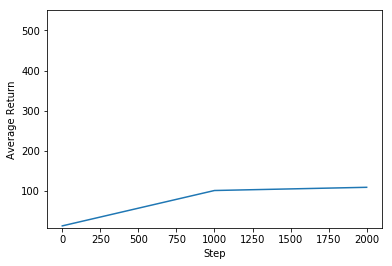

In [16]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [17]:
fig = plt.figure(figsize=(10,5))
plt.plot(q0)
plt.plot(q1)
plt.plot(q2)
plt.plot(q3)

NameError: name 'q0' is not defined

<Figure size 720x360 with 0 Axes>

In [ ]:
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = dqn_agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    eval_py_env.render()